# Understanding Causality

In this notebook we look into Inverse Probability Weighted estimations to understand causality in observational studies.
1. One of the primary challenges in observational studies is confounding, where the relationship between the treatment and outcome is confounded by other variables. Inverse probability estimators help address this issue by balancing covariates between treatment groups. This balancing ensures that treatment assignment is effectively randomized within strata defined by the propensity scores, mimicking the randomization process in experimental studies.
2. By weighting each observation by the inverse of its estimated likelihood score, inverse probability estimators create a pseudo-population where treatment assignment is independent of covariates. This allows for the estimation of causal effects by comparing outcomes between treated and control groups in this pseudo-population. In other words, inverse probability estimators enable researchers to isolate the effect of the treatment from other variables, facilitating causal inference.

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In this example, we'll analyze the Lindner dataset, which comprises data from an observational study involving 996 patients who underwent an initial Percutaneous Coronary Intervention (PCI) at Ohio Heart Health, Christ Hospital, Cincinnati, in 1997. The patients were followed up for a minimum of 6 months by the staff of the Lindner Center.

Observational studies like the Lindner dataset differ from randomized controlled trials (RCTs) in that treatment assignments are not randomly allocated. Instead, patients receive treatments based on clinical decisions or other factors, leading to potential confounding variables that must be carefully addressed in data analysis.

In [12]:
data = pd.read_csv('lindner.csv')
data.head()

,Unnamed: 0,PCI care,Stent,Height,Female,Diabetic,Myocardial infarction,Ejection fraction,Vessels,Died
0,1,1,0,163,1,1,0,56,1,1
1,2,1,0,168,0,0,0,56,1,0
2,3,1,0,188,0,0,0,50,1,0
3,4,1,0,175,0,1,0,50,1,0
4,5,1,0,168,1,0,0,55,1,0


The first step involves estimating the likelihood scores, which represent the probability of receiving the
treatment given the observed covariates (features). 
The likelihood model is trained to predict the probability of treatment ("PCI Care" = 1) based on the covariates. 

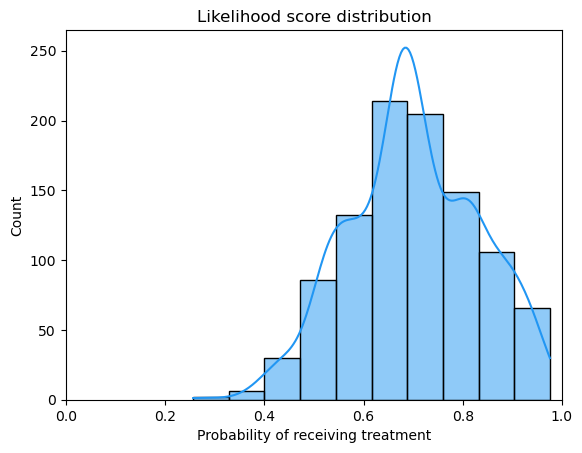

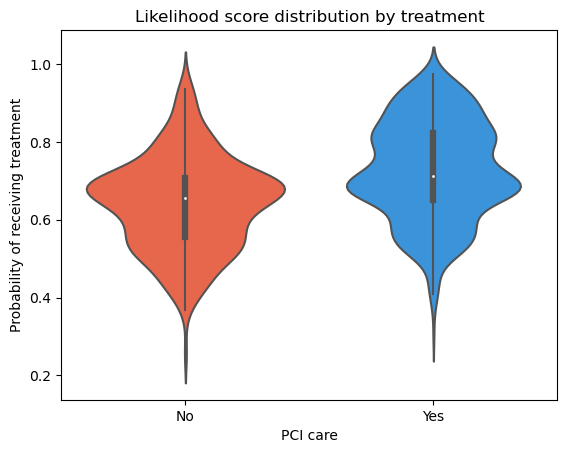

Minimum likelihood score: 0.25647269402199047
Maximum likelihood score: 0.9758692437691764


In [17]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression

# Set key variables
exposure_A = data['PCI care']  # Exposure A
outcome_Y = data['Died']  # Outcome Y
covariates_L = data.loc[:, ['Stent', 'Height', 'Female', 'Diabetic', 'Myocardial infarction', 'Ejection fraction', 'Vessels']]  # Covariates L

# Estimate the odds of receiving treatment Ê[A|L] using a logistic regression model
treatment_model = LogisticRegression(random_state=42)
treatment_model.fit(covariates_L, exposure_A)
treatment_likelihood = treatment_model.predict_proba(covariates_L)[:, 1]


# Visualize the likelihood score distribution in a histogram
colors = ["#FF5733", "#2196F3"]
plt.figure()
ax_histogram = sb.histplot(treatment_likelihood, kde=True, color=colors[1], bins=10)
ax_histogram.set(xlabel='Probability of receiving treatment', title='Likelihood score distribution')
ax_histogram.set_xlim(0, 1)
plt.show()

# Visualize the likelihood score distribution by treatment in a violin plot
plt.figure()
ax_violinplot = sb.violinplot(x=exposure_A, y=treatment_likelihood, palette=colors, alpha=0.55)
ax_violinplot.set(xlabel='PCI care', xticklabels=['No', 'Yes'], ylabel='Probability of receiving treatment', title='Likelihood score distribution by treatment')
plt.show()

# Print minimum and maximum likelihood score values
print("Minimum likelihood score:", min(treatment_likelihood))
print("Maximum likelihood score:", max(treatment_likelihood))

It appears that a substantial portion of patients were inclined to receive the treatment based on their observed characteristics, as reflected in the covariates. This observation aligns with the dataset's context and is not unexpected. However, it's important to note that in a Randomized Controlled Trial (RCT), the likelihood to receive treatment should be evenly distributed between the treatment and control groups.

In an RCT, participants are randomly assigned to either the treatment or control group. Randomization ensures that there's no systematic bias or influence in treatment assignment based on participant characteristics. As a result, the likelihood to receive treatment should be balanced between the two groups, meaning that on average, individuals in both groups have an equal likelihood of being assigned to either treatment or control.

This balance in likelihood is critical for making causal inferences about the treatment effect. When the likelihood to receive treatment is evenly distributed, any observed differences in outcomes between the treatment and control groups can be attributed more confidently to the treatment itself rather than pre-existing differences in participant characteristics.

Next, we build the outcome model, which predicts the likelihood of mortality within a 6-month period based on the observed patient characteristics.
Finally, we use the "Inverse Probability Weighted" estimator to estimate the causal effect of the treatment on the outcome. This step involves calculating P1 and P0 which are the predicted counterfactual outcomes under treatment and under no treatment respectively. 

In [20]:
# Set key variables including covariates and exposure
covariates_with_exposure = data.loc[:, ['PCI care', 'Stent', 'Height', 'Female', 'Diabetic', 'Myocardial infarction', 'Ejection fraction', 'Vessels']]

# Fit logistic regression model to estimate the odds of dying within 6 months Ê[Y|L]
model_Y_given_L = LogisticRegression(random_state=42)
model_Y_given_L.fit(covariates_with_exposure, outcome_Y)

# Predicted counterfactual outcomes under treatment (PCI care = 1)
covariates_all_treated = covariates_with_exposure.copy()
covariates_all_treated['PCI care'] = 1
P1 = model_Y_given_L.predict_proba(covariates_all_treated)[:, 1]

# Predicted counterfactual outcomes under no treatment (PCI care = 0)
covariates_none_treated = covariates_with_exposure.copy()
covariates_none_treated['PCI care'] = 0
P0 = model_Y_given_L.predict_proba(covariates_none_treated)[:, 1]

Subsequently, the average treatment effect is computed by considering potential outcomes under different treatment scenarios and weighting them by the likelihood of receiving each treatment. It quantifies the average difference in outcomes between treated and untreated groups, offering insight into the causal impact of the treatment while addressing confounding variables.

In [21]:
# E[Y^1]
Y1 = np.divide(exposure_A, treatment_likelihood) * (outcome_Y - P1) + P1
EY1 = np.mean(Y1)

# E[Y^0]
Y0 = np.divide((1-exposure_A),(1-treatment_likelihood)) * (outcome_Y - P0) + P0
EY0 = np.mean(Y0)

In [22]:
# Calculate estimated individual causal effects of recieving and not recieving the treatment
eic_EY1 = np.divide(exposure_A, treatment_likelihood) * (outcome_Y - P1) + P1 - EY1
eic_EY0 = np.divide((1-exposure_A),(1-treatment_likelihood)) * (outcome_Y - P0) + P0 - EY0

# Calculate standard errors
se_EY1 = (1/np.sqrt(len(outcome_Y))) * np.std(eic_EY1)
se_EY0 = (1/np.sqrt(len(outcome_Y))) * np.std(eic_EY0)

# Calculate confidence intervals
ci_high_EY1 = EY1 + 1.96 * se_EY1
ci_low_EY1 = EY1 - 1.96 * se_EY1
ci_high_EY0 = EY0 + 1.96 * se_EY0
ci_low_EY0 = EY0 - 1.96 * se_EY0

# Print results
print(
    """
    Odds predicted of dying within 6 months under treatment are {:.2f}% (CI 95%: {:.2f}-{:.2f})
    """.format(EY1 * 100, ci_low_EY1 * 100, ci_high_EY1 * 100),
    )
print(
    """
    Odds predicted of dying within 6 months without treatment are {:.2f}%  (CI 95%: {:.2f}-{:.2f})
    """.format(EY0 * 100, ci_low_EY0 * 100, ci_high_EY0 * 100),
    )
print(
    """
    The odds of dying within 6 months due to the treatment are reduced by {:.2f}%.
    """.format((EY0 - EY1) * 100)
    )


    Odds predicted of dying within 6 months under treatment are 1.53% (CI 95%: 0.62-2.45)
    

    Odds predicted of dying within 6 months without treatment are 7.65%  (CI 95%: 2.83-12.47)
    

    The odds of dying within 6 months due to the treatment are reduced by 6.12%.
    


Now, let's contrast this with a machine learning model that isn't informed by causal relationships and doesn't consider confounding or colliding variables.

In [23]:
# Creating a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Fitting the model to the data
logistic_model.fit(covariates_with_exposure, outcome_Y)

# Printing the analysis results
print(
    """
    The logistic regression model suggests that the likelihood of dying within 6 months is elevated by {}% when recieving treatment.
    """.format(round(logistic_model.coef_[0][0], 2))
)


    The logistic regression model suggests that the likelihood of dying within 6 months is elevated by -1.27% when recieving treatment.
    


In summary, inverse probability estimators serve as powerful tools for understanding causality in observational studies by addressing confounding, estimating causal effects, and modeling complex relationships. These methods help researchers draw meaningful causal inferences from observational data, advancing our understanding of causal relationships in real-world settings.

# References
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8275441/
2. https://towardsdatascience.com/understanding-inverse-probability-of-treatment-weighting-iptw-in-causal-inference-4e69692bce7e
3. https://towardsdatascience.com/an-intuitive-explanation-for-inverse-propensity-weighting-in-causal-inference-459a7e6fa94a